In [2]:
%load_ext autoreload
%autoreload 2

%load_ext line_profiler

import sys
if '../' not in sys.path:
    sys.path.append('../')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [12]:
from matplotlib import pyplot as plt
%matplotlib inline

import networkx as nx
import numpy as np
import argparse
import joblib
import os

from analysis import Evaluation
from dynamics import SIRDynamicalSystem
import helpers
from graph_generation import make_ebola_network

Construct the adjacency  matrix of the propagation network

In [13]:
# net = nx.Graph()
# net.add_edges_from([
#     (0,1), (1,2), (2,3), (3,4), (4,5), (5,6), (6,7), (7,8), (8,9)
# ])
# A = nx.adjacency_matrix(net).toarray().astype(float)

# n_nodes = net.number_of_nodes()
# n_edges = net.number_of_edges()
# print(f"Network: {n_nodes:d} nodes, {n_edges:d} edges")

# X_init = np.zeros(n_nodes)
# X_init[0] = 1

In [23]:
n_nodes = 5000
p_in = 0.1
p_out = p_in / 10

net = make_ebola_network(n_nodes=n_nodes, p_in=p_in, p_out=p_out)
A = nx.adjacency_matrix(net).toarray().astype(float)

n_nodes = net.number_of_nodes()
n_edges = net.number_of_edges()
print(f"Network: {n_nodes:d} nodes, {n_edges:d} edges")

n_seeds = 50
X_init = np.hstack(((np.ones(n_seeds), np.zeros(n_nodes - n_seeds))))
X_init = np.random.permutation(X_init)

print(f"Choose a random set of {X_init.sum():.0f} initial infected seeds")
print()

Network: 4996 nodes, 46370 edges
Choose a random set of 50 initial infected seeds



In [36]:
sim_dict = {
    'total_time': 7.0,
    'trials_per_setting': 5
}
param_dict = {
    'beta':  1.0/15.3,
    'gamma': 1.0/15.3,
    'delta': 1.0/11.4,
    'rho':   1.0/6.0,
    'eta':   1.0
}
cost_dict = {
    'Qlam': 1.0,
    'Qx': 1.0
}
policy_list = [
    'SOC',
]
baselines_dict = {
    'TR': 0.003,
    'MN': 0.0007,
    'LN': 0.0008,
    'LRSR': 22.807,
    'MCM': 22.807,
    'FL_info': {'N': None, 'max_u': None},
}

In [37]:
param_dict
A.shape, X_init.shape

((4996, 4996), (4996,))

In [38]:
system = SIRDynamicalSystem(X_init, net, param_dict, cost_dict, debug=False, verbose=True, notebook=True)

In [39]:
data = system.simulate_policy('NO', baselines_dict, sim_dict, plot=False)

time   7.00/7.00   | S: 1198, I:2940, R: 858, H: 0, lY: 354.38, lW: 257.89, lN: 0.00 | 14.35 iter/s           


In [46]:
X = np.array([system.X[i].value_at(system.ttotal+10) for i in range(system.n_nodes)])
Y = np.array([system.Y[i].value_at(system.ttotal+10) for i in range(system.n_nodes)])
W = np.array([system.W[i].value_at(system.ttotal+10) for i in range(system.n_nodes)])
H = np.array([system.H[i].value_at(system.ttotal+10) for i in range(system.n_nodes)])

In [41]:
X.sum(), H.sum()

(2941.0, 0.0)

In [42]:
Y.sum(), Y.max()

(3799.0, 1.0)

In [43]:
W.sum(), W.max()

(858.0, 1.0)

In [48]:
hf = helpers.HelperFunc()

tspace = np.arange(0.0, 7.0, 0.01)

# Extract the values of the stochastic processes at all times
y_values = np.zeros(len(tspace))
w_values = np.zeros(len(tspace))
for k, t in enumerate(tspace):
    y_values[k] = hf.sps_values(system.Y, t, summed=True)
    w_values[k] = hf.sps_values(system.W, t, summed=True)

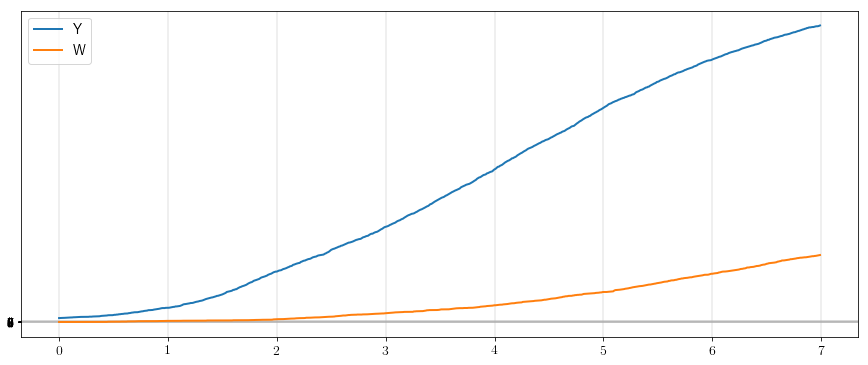

In [49]:
plt.figure(figsize=(15,6))
plt.grid()
plt.plot(tspace, y_values, label='Y')
plt.plot(tspace, w_values, label='W')
plt.xticks(np.arange(0,tspace[-1]+1.0,1.0))
plt.yticks(range(10))
plt.legend();